# GuidedLDA on PROMs

Guided LDA is installed using a work around via import LDA module containing the guided LDA scripts.

1. Formatting the data 
2. Training model
3. Evaluate model
4. Fine tune the model

In [1]:
import pandas as pd
import numpy as np

from lda import guidedlda, glda_datasets
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

from nltk.corpus import wordnet as wn
import nltk

from sklearn.metrics import recall_score, f1_score, precision_score, fbeta_score, accuracy_score


# Loading the data

- Load your csv file
- Extract the requisite tweets from the file
- Clean the data
- Create a dictionary containing each word of the corpus generated
- Build a TDM structure
- Fit the structure to your data file
- Obtain the vocabulary - the TDM features (words)
- Continue using the code above

In [8]:
def load_ftc_data(datafile):
    #load data (dataset specific)
    datadf = pd.read_excel(datafile, 1)
    datadf = datadf[['patient id','q77']]
    datadf = datadf.rename(columns = {'patient id': 'patient_id', 'q77':'comments_raw'})
    
    print("Missing rows: \t", np.where(datadf['comments_raw'].isnull())[0])
    datadf.dropna(subset = ['comments_raw'], inplace=True)
    
    datadf.patient_id = datadf.patient_id.astype(int)
    return datadf

def load_processed_data(datafile):
    #load data (dataset specific)
    datadf = pd.read_excel(datafile)
    print(datadf.columns)
    datadf = datadf[['patient_id','comments_raw','cleaned_comments', "nouns_adj"]]
   
    print("Missing rows: \t", np.where(datadf['cleaned_comments'].isnull())[0])
   
    datadf.patient_id = datadf.patient_id.astype(int)
    return datadf

# Evaluation
def select_labelled(dataf, model, true_labelled ,tfidf, cols = ["Patient ID", "Pateint Comment", "Cormorbidities",
                                                                 "Physcical Function",
                                                                "Psychological & Emotional Function",
                                                                   "Daily Life and Social Function",
                                                                "Cancer Pathway & Services"]):
    '''Selects data that has been labelled by the algorithm, that has the same comments as the true labelled data.
   Returns the dataframe sorted based on comments column. 
   Inputs:
   - dataframe of comments
   - trained model
   - tfidf matrix'''

    topic_df = pd.DataFrame(
        model.transform(tfidf), 
        columns=["topic_{}".format(i+1) for i in range(6)]).astype(float)

    #print(len(topic_df))
    topic_df.index = dataf.index
    dataf = pd.concat([dataf, topic_df], axis=1)

    labelled = dataf.loc[dataf['raw_comments'].isin(true_labelled['Pateint Comment'])]
    labelled = labelled.drop_duplicates(subset="raw_comments")
    
    labelled.columns = [cols]
    labelled = labelled.iloc[:,1:]
    labelled = labelled.sort_values(by=['Pateint Comment'])
    
    return labelled



def predicted_labels(data, themes, threshold = 0.7):
    """ changes the probability (float) to 1/0 labels. The threshold can be changed by the user. """
    bin_labels = []
    comments = predicted_texr['Pateint Comment']
    bin_labs = [comments]

    for x in themes:
        pred_test = pd.Series(np.where(data[x] >= threshold, 1, 0)) 
        bin_labels.append(list(pred_test))  


    bin_labels = np.array(bin_labels).T #.tolist()
    pred_labs = pd.DataFrame(bin_labels, columns= themes)
    return pred_labs, themes


def performance(true, predicted):
    ''' calculates the f1 score, recall, precision and f05 of 2 dataframe.
    returns dataframe of metrics'''
    
    y_true = true.iloc[:,1:].astype(int).to_numpy()
    y_pred = predicted.iloc[:,1:].astype(int).to_numpy()
    

    f1score = f1_score(y_true, y_pred, average = None)
    recall = recall_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average=None, zero_division =1)
#     f05 = fbeta_score(y_true, y_pred, average=None, beta=0.5)
    macrof1 = f1_score(y_true, y_pred, average= 'macro')
    microf1 = f1_score(y_true, y_pred, average= 'micro')
    weight_f1 = f1_score(y_true, y_pred, average= 'weighted')
    
    metrics = {"F1-score":f1score, "Recall": recall, "Precision": precision,
               "Macro F1": macrof1, "Micro F1": microf1, "weighted f1 ": weight_f1}
    
    return pd.DataFrame(metrics)


def precision_recall_(data, true_labs, y_true, comments, themes):
    """ Produces 2 graphs of f1-score vs threshold and precision vs recall."""
    recalls = []
    precisions = []
    f1scores = []

    for x in np.arange(0,1,0.01):
        pred_labs, themes = predicted_labels(data, themes, x)
        pred_labs.insert(0, "Pateint Comment", comments)


        y_pred = pred_labs.iloc[:,1:].astype(int).to_numpy()


        recall = recall_score(y_true, y_pred, average=None)
        precision = precision_score(y_true, y_pred, average=None)
        f1score = f1_score(y_true, y_pred, average=None)
        recalls.append(recall)
        precisions.append(precision)
        f1scores.append(f1score)

    print("### y_pred list ###")
    nprec = np.array(precisions)
    nrec = np.array(recalls)
    nf1 = np.array(f1scores)
    print(nprec.shape)
   

    plt.plot(np.arange(0,1,0.01), nf1[:,0], label ="Comorbidities")
    plt.plot(np.arange(0,1,0.01), nf1[:,1], label ="Physical Function")
    plt.plot(np.arange(0,1,0.01), nf1[:,2], label ="Psych & emotional Function")
    plt.plot(np.arange(0,1,0.01), nf1[:,3], label ="Daily Life")
    plt.plot(np.arange(0,1,0.01), nf1[:,4], label ="Social Function")
    plt.plot(np.arange(0,1,0.01), nf1[:,5], label ="Cancer services and Pathways")
    plt.title('F1-score vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1-score')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    plt.plot(nrec[:,0], nprec[:,0], label ="Comorbidities")
    plt.plot(nrec[:,1], nprec[:,1], label ="Physical Function")
    plt.plot(nrec[:,2], nprec[:,2], label ="Psych & emotional Function")
    plt.plot(nrec[:,3], nprec[:,3], label ="Daily Life")
    plt.plot(nrec[:,4], nprec[:,4], label ="Social Function")
    plt.plot(nrec[:,5], nprec[:,5], label ="Cancer services and Pathways")
    
    plt.title('Precision-recall')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return

In [ ]:
PATH = ""
datafile = "datafile.xlsx"

dataf = load_processed_data(PATH + datafile)

In [ ]:
comments = dataf.comments_raw
comments = list(comments)
noun_adj = dataf.nouns_adj


In [11]:
# load proessed text 
process_comments = dataf.cleaned_comments
process_comments

0       ['colorectal', 'cancer', 'spread', 'liver', 'o...
1       ['major', 'scoliosis', 'osteoporosis', 'chroni...
2       ['advise', 'help', 'urologist', 'cancer', 'fin...
3       ['question', 'tick', 'hearing', 'problem', 'on...
4       ['complete', 'behalf', 'husband', 'cancer', 's...
                              ...                        
5627    ['dear', 'sir', 'laparoscopic', 'colostomy', '...
5628    ['speak', 'gentleman', 'regard', 'survey', 'bo...
5629    ['post', 'cancer', 'op', 'care', 'limit', 'pho...
5630    ['yrs', 'month', 'cancer', 'leave', 'ache', 'l...
5631    ['year', 'age', 'walk', 'bad', 'knee', 'prosta...
Name: cleaned_comments, Length: 5632, dtype: object

# Loading labelled data

In [ ]:
true_labelled = pd.read_excel(PATH + "annotations.xlsx")
true_labelled

In [13]:
# split data in test and train. 
# train_data
train_data = dataf[~dataf["cleaned_comments"].isin(true_labelled["Pateint Comment"])]
train = dataf[~dataf["comments_raw"].isin(true_labelled["Pateint Comment"])]

train_data = train_data.cleaned_comments

# test_data
test = dataf[dataf["cleaned_comments"].isin(true_labelled["Pateint Comment"])]
test = test.cleaned_comments.drop_duplicates(keep="first")
test_data = dataf[dataf["comments_raw"].isin(true_labelled["Pateint Comment"])]


In [14]:
vectorizer = TfidfVectorizer(
    max_df= 0.4,
    min_df= 0.001 ,
    max_features=None,
    ngram_range=(1, 2),
    norm= None,
    binary=True,
    use_idf=False,
    sublinear_tf=False,
    analyzer='word',
    stop_words = 'english'
)

fulldata = vectorizer.fit_transform(process_comments)
vocab = vectorizer.get_feature_names()

train_X = vectorizer.fit_transform(train_data)

test_X = vectorizer.transform(test_data)
tfidf = vectorizer.transform(data.cleaned_comments)

print(len(vocab))

word2id = dict((v, idx) for idx, v in enumerate(vocab))

3019


# Training the model
## Without seed terms

In [ ]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=5000, random_state=7, refresh=20)
model.fit(train_X.toarray().astype(int))

In [85]:
topic_word = model.topic_word_
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: care treatment hospital nurse receive excellent staff thank
Topic 1: cancer help support life feel time live treatment
Topic 2: cancer problem question answer year bowel age condition
Topic 3: cancer scan test check bowel surgery year early
Topic 4: cancer bowel liver bowel cancer lung remove surgery chemotherapy
Topic 5: operation bowel problem day time stoma month surgery


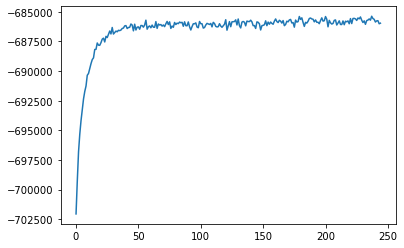

In [86]:
# skipping the first few entries makes the graph more readable
plt.plot(model.loglikelihoods_[5:])

In [87]:
max(model.loglikelihoods_)

-685378.9602005107

In [88]:
model = guidedlda.GuidedLDA(n_topics=7, n_iter=5000, random_state=7, refresh=20)
model.fit(tfidf.toarray().astype(int))

INFO:lda:n_documents: 5632
INFO:lda:vocab_size: 3000
INFO:lda:n_words: 93147
INFO:lda:n_topics: 7
INFO:lda:n_iter: 5000
INFO:lda:<0> log likelihood: -1025215
INFO:lda:<20> log likelihood: -738941
INFO:lda:<40> log likelihood: -723112
INFO:lda:<60> log likelihood: -713792
INFO:lda:<80> log likelihood: -706912
INFO:lda:<100> log likelihood: -703013
INFO:lda:<120> log likelihood: -699539
INFO:lda:<140> log likelihood: -697492
INFO:lda:<160> log likelihood: -695368
INFO:lda:<180> log likelihood: -694521
INFO:lda:<200> log likelihood: -693667
INFO:lda:<220> log likelihood: -692807
INFO:lda:<240> log likelihood: -691966
INFO:lda:<260> log likelihood: -691200
INFO:lda:<280> log likelihood: -690995
INFO:lda:<300> log likelihood: -690442
INFO:lda:<320> log likelihood: -690083
INFO:lda:<340> log likelihood: -690322
INFO:lda:<360> log likelihood: -689076
INFO:lda:<380> log likelihood: -689255
INFO:lda:<400> log likelihood: -689027
INFO:lda:<420> log likelihood: -688975
INFO:lda:<440> log likeliho

INFO:lda:<4040> log likelihood: -686803
INFO:lda:<4060> log likelihood: -686380
INFO:lda:<4080> log likelihood: -686489
INFO:lda:<4100> log likelihood: -686155
INFO:lda:<4120> log likelihood: -686374
INFO:lda:<4140> log likelihood: -686547
INFO:lda:<4160> log likelihood: -685881
INFO:lda:<4180> log likelihood: -686209
INFO:lda:<4200> log likelihood: -686322
INFO:lda:<4220> log likelihood: -686147
INFO:lda:<4240> log likelihood: -685885
INFO:lda:<4260> log likelihood: -685899
INFO:lda:<4280> log likelihood: -686104
INFO:lda:<4300> log likelihood: -686200
INFO:lda:<4320> log likelihood: -686174
INFO:lda:<4340> log likelihood: -686261
INFO:lda:<4360> log likelihood: -686217
INFO:lda:<4380> log likelihood: -686195
INFO:lda:<4400> log likelihood: -686146
INFO:lda:<4420> log likelihood: -686022
INFO:lda:<4440> log likelihood: -685888
INFO:lda:<4460> log likelihood: -686035
INFO:lda:<4480> log likelihood: -685739
INFO:lda:<4500> log likelihood: -685739
INFO:lda:<4520> log likelihood: -685577


In [85]:
topic_word = model.topic_word_
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: bowel bowel cancer scan remove surgery liver diagnose treatment
Topic 1: problem question answer chemotherapy year foot cause age
Topic 2: life help feel live time think positive people
Topic 3: bowel operation stoma day time surgery month hernia
Topic 4: care hospital treatment nurse receive excellent staff support


In [90]:
max(model.loglikelihoods_)

-685493.8152808896

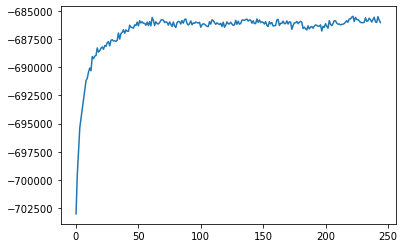

In [91]:
plt.plot(model.loglikelihoods_[5:])

## With seed terms

In [18]:
# Load seed terms
print(PATH)
seeds = pd.read_excel(PATH + "Data/Seed_termsv2.xlsx", sheet_name = "seed_terms_5")

C:/Users/a-lin/OneDrive - University of Leeds/PhD/Experiments/


In [19]:
seeds = seeds.iloc[1:,2]
seeds

1    Myocardial Infarct, angina, coronary artery di...
2    hot sweats, jaundice, skin changes, itching, n...
3     identity, body image, self-confidence, body a...
4    husband, wife, spouse, partner, relationship, ...
5    radiotherapy, chemotherapy, tamoxifen, surgery...
Name: Unnamed: 2, dtype: object

In [20]:
## Process Seed terms

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return '' 

# separate string of seed terms in list of terms and make lower
def split_seedterm(seeds_string):
    seed_terms = []

    for i in range(len(seeds_string)):
        theme = []
        # print(seeds_string.iloc[i])
        seed_list = seeds_string.iloc[i].split(",")
        for el in seed_list:
            el = el.strip().lower()
            theme.append(el)
        seed_terms.append(theme)
    return seed_terms

   

def process_seeds(seed_terms):
    seed_termss = []

    for topic in seed_terms:
        theme = []
        for phrase in topic:
            phrases = []
            token = []
            words = nltk.word_tokenize(phrase)
            token = [word.lower() for word in words if word.lower() not in stop_words]

            tagtoken = nltk.pos_tag(token)

            for tok, tag in tagtoken:
                wntag = get_wordnet_pos(tag)

                if wntag == '':
                    lemma = lemmatiser.lemmatize(tok)
                else:
                    lemma = lemmatiser.lemmatize(tok, pos=wntag)
                phrases.append(lemma)
            theme.append(" ".join(phrases))

        seed_termss.append(theme)
    return seed_termss

In [21]:
stop_words = nltk.corpus.stopwords.words("english")             # List of all the stop words in english 
lemmatiser = nltk.stem.WordNetLemmatizer()

seed_terms = split_seedterm(seeds)
seed_terms = process_seeds(seed_terms)
seed_words = [[a for a in topic if a in vocab] for topic in seed_terms]

seed_words

[['angina',
  'heart failure',
  'copd',
  'asthma',
  'ulcer',
  'stroke',
  'dementia',
  'parkinson',
  'depression',
  'aid',
  'melanoma',
  'lymphoma',
  'arthritis',
  'old age',
  'anxiety'],
 ['nausea',
  'peripheral neuropathy',
  'bleeding',
  'cough',
  'cold',
  'fracture',
  'vomit',
  'sex life',
  'sleep',
  'weight',
  'appetite',
  'weight loss',
  'pain',
  'ache',
  'nausea',
  'constipation',
  'diarrhoea',
  'wind',
  'constipation',
  'bowel movement',
  'fatigue',
  'weakness',
  'tiredness',
  'energy',
  'strength',
  'memory',
  'concentration',
  'balance',
  'mobility problem',
  'sex'],
 ['embarrassment',
  'fear',
  'afraid',
  'loss',
  'worry',
  'emotional',
  'gratitude',
  'relief',
  'hope',
  'peace',
  'faith',
  'cop',
  'pray',
  'embarrass',
  'cope',
  'worried',
  'confidence',
  'mood',
  'positive attitude',
  'depressed',
  'anxious',
  'optimistic',
  'attitude'],
 ['husband',
  'wife',
  'spouse',
  'partner',
  'grandchild',
  'family',

In [22]:
pd.DataFrame(seed_words).to_excel(PATH + "seed_terms_in_vocab.xlsx")

In [90]:
seed_topics

{89: 0,
 1172: 0,
 624: 0,
 152: 0,
 2832: 0,
 2541: 0,
 699: 0,
 1887: 0,
 705: 0,
 70: 0,
 1609: 0,
 1545: 0,
 139: 0,
 1796: 0,
 106: 0,
 1686: 1,
 1926: 1,
 224: 1,
 630: 1,
 527: 1,
 1052: 1,
 2901: 1,
 2398: 1,
 2434: 1,
 2951: 1,
 117: 1,
 2952: 1,
 1875: 1,
 17: 1,
 601: 1,
 737: 1,
 2965: 1,
 253: 1,
 945: 1,
 2933: 1,
 2734: 1,
 853: 1,
 2537: 1,
 1612: 1,
 575: 1,
 185: 1,
 1638: 1,
 2397: 1,
 832: 2,
 948: 2,
 55: 2,
 1515: 2,
 2985: 2,
 836: 2,
 1127: 2,
 2212: 2,
 1220: 2,
 1908: 2,
 932: 2,
 623: 2,
 2005: 2,
 830: 2,
 625: 2,
 2984: 2,
 581: 2,
 1663: 2,
 1978: 2,
 704: 2,
 107: 2,
 1842: 2,
 162: 2,
 1265: 3,
 2961: 3,
 2479: 3,
 1894: 3,
 1117: 3,
 934: 3,
 2754: 3,
 2911: 3,
 2877: 3,
 25: 3,
 1446: 3,
 798: 3,
 740: 3,
 1367: 3,
 844: 3,
 986: 3,
 1335: 3,
 1640: 3,
 1445: 3,
 1260: 3,
 898: 3,
 501: 3,
 2574: 3,
 2447: 3,
 1058: 3,
 558: 3,
 23: 3,
 1941: 3,
 795: 3,
 1208: 3,
 2924: 3,
 702: 3,
 2448: 3,
 1362: 3,
 1361: 3,
 2756: 3,
 2117: 4,
 487: 4,
 2601: 4,
 

In [84]:
# Run Model
model = guidedlda.GuidedLDA(n_topics=2, n_iter=5000,
                            random_state=7, refresh=10, 
                            alpha=0.4, eta=0.2)

#seed_topics is the dictionary {word_id to topic_id}
seed_topics = {}
for t_id, st in enumerate(seed_words):
    for word in st:
        seed_topics[word2id[word]] = t_id
        
model.fit(fulldata.toarray().astype(int), seed_topics=seed_words, seed_confidence=0.7)

topic_df = pd.DataFrame(model.transform(fulldata.toarray().astype(int)), 
                        columns=["topic_{}".format(i+1) for i in range(5)]
                       ).astype(float)

# topic_df.to_excel(PATH + "glda_5themes_predictions_{}.xlsx".format(i))

topic_df

INFO:lda:n_documents: 5632
INFO:lda:vocab_size: 3019
INFO:lda:n_words: 91999
INFO:lda:n_topics: 2
INFO:lda:n_iter: 5000
C:\Users\a-lin\anaconda3\envs\phdproject\lib\site-packages\lda\guidedlda.py:303: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if w not in seed_topics:
C:\Users\a-lin\anaconda3\envs\phdproject\lib\site-packages\lda\guidedlda.py:318: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if w in seed_topics:
INFO:lda:<0> log likelihood: -737876
INFO:lda:<10> log likelihood: -690220
INFO:lda:<20> log likelihood: -673462
INFO:lda:<30> log likelihood: -672645
INFO:lda:<40> log likelihood: -672897
INFO:lda:<50> log likelihood: -672633
INFO:lda:<60> log likelihood: -672808
INFO:lda:<70> log likelihood: -672803
INFO:lda:<80> log likelihood: -672854
INFO:lda:<90> log likelihood: -672486
INFO:lda:<100> log likelihood: -67283

INFO:lda:<1920> log likelihood: -672759
INFO:lda:<1930> log likelihood: -673003
INFO:lda:<1940> log likelihood: -672887
INFO:lda:<1950> log likelihood: -672824
INFO:lda:<1960> log likelihood: -672983
INFO:lda:<1970> log likelihood: -672515
INFO:lda:<1980> log likelihood: -673021
INFO:lda:<1990> log likelihood: -672857
INFO:lda:<2000> log likelihood: -672823
INFO:lda:<2010> log likelihood: -673143
INFO:lda:<2020> log likelihood: -672736
INFO:lda:<2030> log likelihood: -672921
INFO:lda:<2040> log likelihood: -672962
INFO:lda:<2050> log likelihood: -673023
INFO:lda:<2060> log likelihood: -672771
INFO:lda:<2070> log likelihood: -672664
INFO:lda:<2080> log likelihood: -672707
INFO:lda:<2090> log likelihood: -672832
INFO:lda:<2100> log likelihood: -672812
INFO:lda:<2110> log likelihood: -672975
INFO:lda:<2120> log likelihood: -672565
INFO:lda:<2130> log likelihood: -672753
INFO:lda:<2140> log likelihood: -672740
INFO:lda:<2150> log likelihood: -672904
INFO:lda:<2160> log likelihood: -672655


INFO:lda:<3970> log likelihood: -673003
INFO:lda:<3980> log likelihood: -672713
INFO:lda:<3990> log likelihood: -672877
INFO:lda:<4000> log likelihood: -672777
INFO:lda:<4010> log likelihood: -672920
INFO:lda:<4020> log likelihood: -672762
INFO:lda:<4030> log likelihood: -673093
INFO:lda:<4040> log likelihood: -673000
INFO:lda:<4050> log likelihood: -673045
INFO:lda:<4060> log likelihood: -672806
INFO:lda:<4070> log likelihood: -672923
INFO:lda:<4080> log likelihood: -673331
INFO:lda:<4090> log likelihood: -672814
INFO:lda:<4100> log likelihood: -672807
INFO:lda:<4110> log likelihood: -673003
INFO:lda:<4120> log likelihood: -672927
INFO:lda:<4130> log likelihood: -673330
INFO:lda:<4140> log likelihood: -673080
INFO:lda:<4150> log likelihood: -672667
INFO:lda:<4160> log likelihood: -672995
INFO:lda:<4170> log likelihood: -672972
INFO:lda:<4180> log likelihood: -672999
INFO:lda:<4190> log likelihood: -672796
INFO:lda:<4200> log likelihood: -672625
INFO:lda:<4210> log likelihood: -672584


ValueError: Shape of passed values is (5632, 2), indices imply (5632, 5)

In [79]:
model.fit(fulldata.toarray().astype(int), seed_topics=seed_words[0], seed_confidence=0.7)
topic_df = pd.DataFrame(model.transform(fulldata.toarray().astype(int)), 
                        columns=["topic_{}".format(i+1) for i in range(2)]
                       ).astype(float)

topic_df.to_excel(PATH + "glda_5themes_predictions_1.xlsx")

topic_df

INFO:lda:n_documents: 5632
INFO:lda:vocab_size: 3019
INFO:lda:n_words: 91999
INFO:lda:n_topics: 2
INFO:lda:n_iter: 5000
INFO:lda:<0> log likelihood: -740702
INFO:lda:<10> log likelihood: -690327
INFO:lda:<20> log likelihood: -673201
INFO:lda:<30> log likelihood: -672063
INFO:lda:<40> log likelihood: -671570
INFO:lda:<50> log likelihood: -671473
INFO:lda:<60> log likelihood: -671524
INFO:lda:<70> log likelihood: -671582
INFO:lda:<80> log likelihood: -671525
INFO:lda:<90> log likelihood: -671303
INFO:lda:<100> log likelihood: -671600
INFO:lda:<110> log likelihood: -671792
INFO:lda:<120> log likelihood: -671581
INFO:lda:<130> log likelihood: -671640
INFO:lda:<140> log likelihood: -671725
INFO:lda:<150> log likelihood: -671733
INFO:lda:<160> log likelihood: -671840
INFO:lda:<170> log likelihood: -671410
INFO:lda:<180> log likelihood: -671891
INFO:lda:<190> log likelihood: -671637
INFO:lda:<200> log likelihood: -671794
INFO:lda:<210> log likelihood: -671681
INFO:lda:<220> log likelihood: -6

INFO:lda:<2040> log likelihood: -671525
INFO:lda:<2050> log likelihood: -671758
INFO:lda:<2060> log likelihood: -671790
INFO:lda:<2070> log likelihood: -671603
INFO:lda:<2080> log likelihood: -671499
INFO:lda:<2090> log likelihood: -671791
INFO:lda:<2100> log likelihood: -671720
INFO:lda:<2110> log likelihood: -671851
INFO:lda:<2120> log likelihood: -671496
INFO:lda:<2130> log likelihood: -671565
INFO:lda:<2140> log likelihood: -671365
INFO:lda:<2150> log likelihood: -671754
INFO:lda:<2160> log likelihood: -671745
INFO:lda:<2170> log likelihood: -671907
INFO:lda:<2180> log likelihood: -671679
INFO:lda:<2190> log likelihood: -671578
INFO:lda:<2200> log likelihood: -671589
INFO:lda:<2210> log likelihood: -671651
INFO:lda:<2220> log likelihood: -671426
INFO:lda:<2230> log likelihood: -671727
INFO:lda:<2240> log likelihood: -671562
INFO:lda:<2250> log likelihood: -671377
INFO:lda:<2260> log likelihood: -671828
INFO:lda:<2270> log likelihood: -671801
INFO:lda:<2280> log likelihood: -671958


INFO:lda:<4090> log likelihood: -671607
INFO:lda:<4100> log likelihood: -671830
INFO:lda:<4110> log likelihood: -671804
INFO:lda:<4120> log likelihood: -671788
INFO:lda:<4130> log likelihood: -671912
INFO:lda:<4140> log likelihood: -671824
INFO:lda:<4150> log likelihood: -671636
INFO:lda:<4160> log likelihood: -672019
INFO:lda:<4170> log likelihood: -671665
INFO:lda:<4180> log likelihood: -671582
INFO:lda:<4190> log likelihood: -671577
INFO:lda:<4200> log likelihood: -671607
INFO:lda:<4210> log likelihood: -671491
INFO:lda:<4220> log likelihood: -671723
INFO:lda:<4230> log likelihood: -671558
INFO:lda:<4240> log likelihood: -671863
INFO:lda:<4250> log likelihood: -671339
INFO:lda:<4260> log likelihood: -671586
INFO:lda:<4270> log likelihood: -671946
INFO:lda:<4280> log likelihood: -671588
INFO:lda:<4290> log likelihood: -671625
INFO:lda:<4300> log likelihood: -671597
INFO:lda:<4310> log likelihood: -671852
INFO:lda:<4320> log likelihood: -671647
INFO:lda:<4330> log likelihood: -672053


,topic_1,topic_2
0,0.994763,0.005237
1,0.976408,0.023592
2,0.509033,0.490967
3,0.970588,0.029412
4,0.340323,0.659677
...,...,...
5627,0.021459,0.978541
5628,0.530210,0.469790
5629,0.118131,0.881869
5630,0.932423,0.067577


In [73]:
model.fit(fulldata.toarray().astype(int), seed_topics=seed_words[1], seed_confidence=0.7)
topic_df = pd.DataFrame(model.transform(fulldata.toarray().astype(int)), 
                        columns=["topic_{}".format(i+1) for i in range(2)]
                       ).astype(float)

topic_df.to_excel(PATH + "glda_5themes_predictions_2.xlsx")

topic_df

INFO:lda:n_documents: 5632
INFO:lda:vocab_size: 3019
INFO:lda:n_words: 91999
INFO:lda:n_topics: 2
INFO:lda:n_iter: 5000
INFO:lda:<0> log likelihood: -743908
INFO:lda:<10> log likelihood: -689872
INFO:lda:<20> log likelihood: -673928
INFO:lda:<30> log likelihood: -670659
INFO:lda:<40> log likelihood: -669876
INFO:lda:<50> log likelihood: -669444
INFO:lda:<60> log likelihood: -669563
INFO:lda:<70> log likelihood: -669744
INFO:lda:<80> log likelihood: -669547
INFO:lda:<90> log likelihood: -669541
INFO:lda:<100> log likelihood: -669797
INFO:lda:<110> log likelihood: -669765
INFO:lda:<120> log likelihood: -669789
INFO:lda:<130> log likelihood: -669489
INFO:lda:<140> log likelihood: -670040
INFO:lda:<150> log likelihood: -669999
INFO:lda:<160> log likelihood: -669880
INFO:lda:<170> log likelihood: -669592
INFO:lda:<180> log likelihood: -669728
INFO:lda:<190> log likelihood: -669613
INFO:lda:<200> log likelihood: -669882
INFO:lda:<210> log likelihood: -670004
INFO:lda:<220> log likelihood: -6

INFO:lda:<2040> log likelihood: -669667
INFO:lda:<2050> log likelihood: -669798
INFO:lda:<2060> log likelihood: -669684
INFO:lda:<2070> log likelihood: -669930
INFO:lda:<2080> log likelihood: -669721
INFO:lda:<2090> log likelihood: -669924
INFO:lda:<2100> log likelihood: -669806
INFO:lda:<2110> log likelihood: -669986
INFO:lda:<2120> log likelihood: -669695
INFO:lda:<2130> log likelihood: -669624
INFO:lda:<2140> log likelihood: -669479
INFO:lda:<2150> log likelihood: -670015
INFO:lda:<2160> log likelihood: -669708
INFO:lda:<2170> log likelihood: -669470
INFO:lda:<2180> log likelihood: -669860
INFO:lda:<2190> log likelihood: -669467
INFO:lda:<2200> log likelihood: -669693
INFO:lda:<2210> log likelihood: -669691
INFO:lda:<2220> log likelihood: -669869
INFO:lda:<2230> log likelihood: -670223
INFO:lda:<2240> log likelihood: -669790
INFO:lda:<2250> log likelihood: -669930
INFO:lda:<2260> log likelihood: -670012
INFO:lda:<2270> log likelihood: -669840
INFO:lda:<2280> log likelihood: -670170


INFO:lda:<4090> log likelihood: -669623
INFO:lda:<4100> log likelihood: -669816
INFO:lda:<4110> log likelihood: -669747
INFO:lda:<4120> log likelihood: -669978
INFO:lda:<4130> log likelihood: -669775
INFO:lda:<4140> log likelihood: -669862
INFO:lda:<4150> log likelihood: -669700
INFO:lda:<4160> log likelihood: -669995
INFO:lda:<4170> log likelihood: -669687
INFO:lda:<4180> log likelihood: -669693
INFO:lda:<4190> log likelihood: -669742
INFO:lda:<4200> log likelihood: -669862
INFO:lda:<4210> log likelihood: -669728
INFO:lda:<4220> log likelihood: -670080
INFO:lda:<4230> log likelihood: -669862
INFO:lda:<4240> log likelihood: -670015
INFO:lda:<4250> log likelihood: -669799
INFO:lda:<4260> log likelihood: -669831
INFO:lda:<4270> log likelihood: -670157
INFO:lda:<4280> log likelihood: -669736
INFO:lda:<4290> log likelihood: -669793
INFO:lda:<4300> log likelihood: -669744
INFO:lda:<4310> log likelihood: -669822
INFO:lda:<4320> log likelihood: -669824
INFO:lda:<4330> log likelihood: -670197


,topic_1,topic_2
0,0.997142,0.002858
1,0.986756,0.013244
2,0.437706,0.562294
3,0.980960,0.019040
4,0.411414,0.588586
...,...,...
5627,0.012589,0.987411
5628,0.542845,0.457155
5629,0.044461,0.955539
5630,0.963119,0.036881


In [75]:
model.fit(fulldata.toarray().astype(int), seed_topics=seed_words[2], seed_confidence=0.7)
topic_df = pd.DataFrame(model.transform(fulldata.toarray().astype(int)), 
                        columns=["topic_{}".format(i+1) for i in range(2)]
                       ).astype(float)

topic_df.to_excel(PATH + "glda_5themes_predictions_3.xlsx")

topic_df

INFO:lda:n_documents: 5632
INFO:lda:vocab_size: 3019
INFO:lda:n_words: 91999
INFO:lda:n_topics: 2
INFO:lda:n_iter: 5000
INFO:lda:<0> log likelihood: -743908
INFO:lda:<10> log likelihood: -689872
INFO:lda:<20> log likelihood: -673928
INFO:lda:<30> log likelihood: -670659
INFO:lda:<40> log likelihood: -669876
INFO:lda:<50> log likelihood: -669444
INFO:lda:<60> log likelihood: -669563
INFO:lda:<70> log likelihood: -669744
INFO:lda:<80> log likelihood: -669547
INFO:lda:<90> log likelihood: -669541
INFO:lda:<100> log likelihood: -669797
INFO:lda:<110> log likelihood: -669765
INFO:lda:<120> log likelihood: -669789
INFO:lda:<130> log likelihood: -669489
INFO:lda:<140> log likelihood: -670040
INFO:lda:<150> log likelihood: -669999
INFO:lda:<160> log likelihood: -669880
INFO:lda:<170> log likelihood: -669592
INFO:lda:<180> log likelihood: -669728
INFO:lda:<190> log likelihood: -669613
INFO:lda:<200> log likelihood: -669882
INFO:lda:<210> log likelihood: -670004
INFO:lda:<220> log likelihood: -6

INFO:lda:<2040> log likelihood: -669667
INFO:lda:<2050> log likelihood: -669798
INFO:lda:<2060> log likelihood: -669684
INFO:lda:<2070> log likelihood: -669930
INFO:lda:<2080> log likelihood: -669721
INFO:lda:<2090> log likelihood: -669924
INFO:lda:<2100> log likelihood: -669806
INFO:lda:<2110> log likelihood: -669986
INFO:lda:<2120> log likelihood: -669695
INFO:lda:<2130> log likelihood: -669624
INFO:lda:<2140> log likelihood: -669479
INFO:lda:<2150> log likelihood: -670015
INFO:lda:<2160> log likelihood: -669708
INFO:lda:<2170> log likelihood: -669470
INFO:lda:<2180> log likelihood: -669860
INFO:lda:<2190> log likelihood: -669467
INFO:lda:<2200> log likelihood: -669693
INFO:lda:<2210> log likelihood: -669691
INFO:lda:<2220> log likelihood: -669869
INFO:lda:<2230> log likelihood: -670223
INFO:lda:<2240> log likelihood: -669790
INFO:lda:<2250> log likelihood: -669930
INFO:lda:<2260> log likelihood: -670012
INFO:lda:<2270> log likelihood: -669840
INFO:lda:<2280> log likelihood: -670170


INFO:lda:<4090> log likelihood: -669623
INFO:lda:<4100> log likelihood: -669816
INFO:lda:<4110> log likelihood: -669747
INFO:lda:<4120> log likelihood: -669978
INFO:lda:<4130> log likelihood: -669775
INFO:lda:<4140> log likelihood: -669862
INFO:lda:<4150> log likelihood: -669700
INFO:lda:<4160> log likelihood: -669995
INFO:lda:<4170> log likelihood: -669687
INFO:lda:<4180> log likelihood: -669693
INFO:lda:<4190> log likelihood: -669742
INFO:lda:<4200> log likelihood: -669862
INFO:lda:<4210> log likelihood: -669728
INFO:lda:<4220> log likelihood: -670080
INFO:lda:<4230> log likelihood: -669862
INFO:lda:<4240> log likelihood: -670015
INFO:lda:<4250> log likelihood: -669799
INFO:lda:<4260> log likelihood: -669831
INFO:lda:<4270> log likelihood: -670157
INFO:lda:<4280> log likelihood: -669736
INFO:lda:<4290> log likelihood: -669793
INFO:lda:<4300> log likelihood: -669744
INFO:lda:<4310> log likelihood: -669822
INFO:lda:<4320> log likelihood: -669824
INFO:lda:<4330> log likelihood: -670197


,topic_1,topic_2
0,0.997142,0.002858
1,0.986756,0.013244
2,0.437706,0.562294
3,0.980960,0.019040
4,0.411414,0.588586
...,...,...
5627,0.012589,0.987411
5628,0.542845,0.457155
5629,0.044461,0.955539
5630,0.963119,0.036881


In [76]:
model.fit(fulldata.toarray().astype(int), seed_topics=seed_words[3], seed_confidence=0.7)
topic_df = pd.DataFrame(model.transform(fulldata.toarray().astype(int)), 
                        columns=["topic_{}".format(i+1) for i in range(2)]
                       ).astype(float)

topic_df.to_excel(PATH + "glda_5themes_predictions_4.xlsx")

topic_df

INFO:lda:n_documents: 5632
INFO:lda:vocab_size: 3019
INFO:lda:n_words: 91999
INFO:lda:n_topics: 2
INFO:lda:n_iter: 5000
INFO:lda:<0> log likelihood: -743908
INFO:lda:<10> log likelihood: -689872
INFO:lda:<20> log likelihood: -673928
INFO:lda:<30> log likelihood: -670659
INFO:lda:<40> log likelihood: -669876
INFO:lda:<50> log likelihood: -669444
INFO:lda:<60> log likelihood: -669563
INFO:lda:<70> log likelihood: -669744
INFO:lda:<80> log likelihood: -669547
INFO:lda:<90> log likelihood: -669541
INFO:lda:<100> log likelihood: -669797
INFO:lda:<110> log likelihood: -669765
INFO:lda:<120> log likelihood: -669789
INFO:lda:<130> log likelihood: -669489
INFO:lda:<140> log likelihood: -670040
INFO:lda:<150> log likelihood: -669999
INFO:lda:<160> log likelihood: -669880
INFO:lda:<170> log likelihood: -669592
INFO:lda:<180> log likelihood: -669728
INFO:lda:<190> log likelihood: -669613
INFO:lda:<200> log likelihood: -669882
INFO:lda:<210> log likelihood: -670004
INFO:lda:<220> log likelihood: -6

INFO:lda:<2040> log likelihood: -669667
INFO:lda:<2050> log likelihood: -669798
INFO:lda:<2060> log likelihood: -669684
INFO:lda:<2070> log likelihood: -669930
INFO:lda:<2080> log likelihood: -669721
INFO:lda:<2090> log likelihood: -669924
INFO:lda:<2100> log likelihood: -669806
INFO:lda:<2110> log likelihood: -669986
INFO:lda:<2120> log likelihood: -669695
INFO:lda:<2130> log likelihood: -669624
INFO:lda:<2140> log likelihood: -669479
INFO:lda:<2150> log likelihood: -670015
INFO:lda:<2160> log likelihood: -669708
INFO:lda:<2170> log likelihood: -669470
INFO:lda:<2180> log likelihood: -669860
INFO:lda:<2190> log likelihood: -669467
INFO:lda:<2200> log likelihood: -669693
INFO:lda:<2210> log likelihood: -669691
INFO:lda:<2220> log likelihood: -669869
INFO:lda:<2230> log likelihood: -670223
INFO:lda:<2240> log likelihood: -669790
INFO:lda:<2250> log likelihood: -669930
INFO:lda:<2260> log likelihood: -670012
INFO:lda:<2270> log likelihood: -669840
INFO:lda:<2280> log likelihood: -670170


INFO:lda:<4090> log likelihood: -669623
INFO:lda:<4100> log likelihood: -669816
INFO:lda:<4110> log likelihood: -669747
INFO:lda:<4120> log likelihood: -669978
INFO:lda:<4130> log likelihood: -669775
INFO:lda:<4140> log likelihood: -669862
INFO:lda:<4150> log likelihood: -669700
INFO:lda:<4160> log likelihood: -669995
INFO:lda:<4170> log likelihood: -669687
INFO:lda:<4180> log likelihood: -669693
INFO:lda:<4190> log likelihood: -669742
INFO:lda:<4200> log likelihood: -669862
INFO:lda:<4210> log likelihood: -669728
INFO:lda:<4220> log likelihood: -670080
INFO:lda:<4230> log likelihood: -669862
INFO:lda:<4240> log likelihood: -670015
INFO:lda:<4250> log likelihood: -669799
INFO:lda:<4260> log likelihood: -669831
INFO:lda:<4270> log likelihood: -670157
INFO:lda:<4280> log likelihood: -669736
INFO:lda:<4290> log likelihood: -669793
INFO:lda:<4300> log likelihood: -669744
INFO:lda:<4310> log likelihood: -669822
INFO:lda:<4320> log likelihood: -669824
INFO:lda:<4330> log likelihood: -670197


,topic_1,topic_2
0,0.997142,0.002858
1,0.986756,0.013244
2,0.437706,0.562294
3,0.980960,0.019040
4,0.411414,0.588586
...,...,...
5627,0.012589,0.987411
5628,0.542845,0.457155
5629,0.044461,0.955539
5630,0.963119,0.036881


In [77]:
model.fit(fulldata.toarray().astype(int), seed_topics=seed_words[4], seed_confidence=0.7)
topic_df = pd.DataFrame(model.transform(fulldata.toarray().astype(int)), 
                        columns=["topic_{}".format(i+1) for i in range(2)]
                       ).astype(float)

topic_df.to_excel(PATH + "glda_5themes_predictions_5.xlsx")

topic_df

INFO:lda:n_documents: 5632
INFO:lda:vocab_size: 3019
INFO:lda:n_words: 91999
INFO:lda:n_topics: 2
INFO:lda:n_iter: 5000
INFO:lda:<0> log likelihood: -743908
INFO:lda:<10> log likelihood: -689872
INFO:lda:<20> log likelihood: -673928
INFO:lda:<30> log likelihood: -670659
INFO:lda:<40> log likelihood: -669876
INFO:lda:<50> log likelihood: -669444
INFO:lda:<60> log likelihood: -669563
INFO:lda:<70> log likelihood: -669744
INFO:lda:<80> log likelihood: -669547
INFO:lda:<90> log likelihood: -669541
INFO:lda:<100> log likelihood: -669797
INFO:lda:<110> log likelihood: -669765
INFO:lda:<120> log likelihood: -669789
INFO:lda:<130> log likelihood: -669489
INFO:lda:<140> log likelihood: -670040
INFO:lda:<150> log likelihood: -669999
INFO:lda:<160> log likelihood: -669880
INFO:lda:<170> log likelihood: -669592
INFO:lda:<180> log likelihood: -669728
INFO:lda:<190> log likelihood: -669613
INFO:lda:<200> log likelihood: -669882
INFO:lda:<210> log likelihood: -670004
INFO:lda:<220> log likelihood: -6

INFO:lda:<2040> log likelihood: -669667
INFO:lda:<2050> log likelihood: -669798
INFO:lda:<2060> log likelihood: -669684
INFO:lda:<2070> log likelihood: -669930
INFO:lda:<2080> log likelihood: -669721
INFO:lda:<2090> log likelihood: -669924
INFO:lda:<2100> log likelihood: -669806
INFO:lda:<2110> log likelihood: -669986
INFO:lda:<2120> log likelihood: -669695
INFO:lda:<2130> log likelihood: -669624
INFO:lda:<2140> log likelihood: -669479
INFO:lda:<2150> log likelihood: -670015
INFO:lda:<2160> log likelihood: -669708
INFO:lda:<2170> log likelihood: -669470
INFO:lda:<2180> log likelihood: -669860
INFO:lda:<2190> log likelihood: -669467
INFO:lda:<2200> log likelihood: -669693
INFO:lda:<2210> log likelihood: -669691
INFO:lda:<2220> log likelihood: -669869
INFO:lda:<2230> log likelihood: -670223
INFO:lda:<2240> log likelihood: -669790
INFO:lda:<2250> log likelihood: -669930
INFO:lda:<2260> log likelihood: -670012
INFO:lda:<2270> log likelihood: -669840
INFO:lda:<2280> log likelihood: -670170


INFO:lda:<4090> log likelihood: -669623
INFO:lda:<4100> log likelihood: -669816
INFO:lda:<4110> log likelihood: -669747
INFO:lda:<4120> log likelihood: -669978
INFO:lda:<4130> log likelihood: -669775
INFO:lda:<4140> log likelihood: -669862
INFO:lda:<4150> log likelihood: -669700
INFO:lda:<4160> log likelihood: -669995
INFO:lda:<4170> log likelihood: -669687
INFO:lda:<4180> log likelihood: -669693
INFO:lda:<4190> log likelihood: -669742
INFO:lda:<4200> log likelihood: -669862
INFO:lda:<4210> log likelihood: -669728
INFO:lda:<4220> log likelihood: -670080
INFO:lda:<4230> log likelihood: -669862
INFO:lda:<4240> log likelihood: -670015
INFO:lda:<4250> log likelihood: -669799
INFO:lda:<4260> log likelihood: -669831
INFO:lda:<4270> log likelihood: -670157
INFO:lda:<4280> log likelihood: -669736
INFO:lda:<4290> log likelihood: -669793
INFO:lda:<4300> log likelihood: -669744
INFO:lda:<4310> log likelihood: -669822
INFO:lda:<4320> log likelihood: -669824
INFO:lda:<4330> log likelihood: -670197


,topic_1,topic_2
0,0.997142,0.002858
1,0.986756,0.013244
2,0.437706,0.562294
3,0.980960,0.019040
4,0.411414,0.588586
...,...,...
5627,0.012589,0.987411
5628,0.542845,0.457155
5629,0.044461,0.955539
5630,0.963119,0.036881


In [ ]:
# saving model 

import pickle
#filename = 'New_themes_anchor_16112021.sav'
filename = "C:/Users/a-lin/OneDrive - University of Leeds/PhD/Experiments/Guided-LDA/Analysis/model_23082022.sav"

# # save the model to disk
pickle.dump(model, open(filename, 'wb'))

# some time later...

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# model = loaded_model
# topics = loaded_model.get_topics()
# topics


## Model outputs

-688320.0781685008


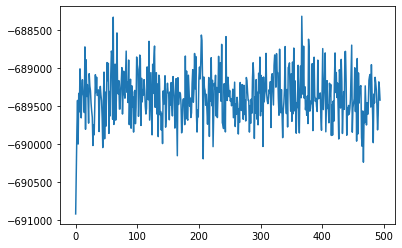

In [59]:
print(max(model.loglikelihoods_))
plt.plot(model.loglikelihoods_[5:])

In [60]:
# Print the most associated word and save as a dataframe
topic_word = model.topic_word_
n_top_words = 25
assoc_words =[]

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
#     print('Topic {}: {}'.format(i, ' '.join(topic_words)))
    assoc_words.append(', '.join(topic_words))
    
keyword_df = pd.DataFrame(assoc_words)
keyword_df

,0
0,"life, feel, help, live, think, time, positive,..."
1,"scan, surgery, check, test, year, month, early..."
2,"bowel, bowel cancer, liver, operation, remove,..."
3,"care, hospital, treatment, nurse, receive, exc..."
4,"problem, bowel, operation, time, cause, pain, ..."


In [63]:
topic_df = pd.DataFrame(
    model.transform(fulldata.toarray().astype(int)), 
    columns=["topic_{}".format(i+1) for i in range(5)]
).astype(float)

topic_df

,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.012887,0.016678,0.933084,0.002311,0.035040
1,0.013641,0.005078,0.063468,0.003712,0.914101
2,0.298746,0.170443,0.162389,0.095154,0.273268
3,0.030273,0.029486,0.034443,0.029915,0.875883
4,0.531213,0.056263,0.288601,0.106182,0.017741
...,...,...,...,...,...
5627,0.368980,0.028507,0.157893,0.431609,0.013011
5628,0.024421,0.605695,0.138475,0.222823,0.008586
5629,0.013588,0.041538,0.026376,0.775404,0.143095
5630,0.072455,0.074103,0.156369,0.007274,0.689799


In [64]:
topic_df.to_excel(PATH + "glda_5themes_predictions.xlsx")

In [62]:
# Evaluation
def select_labelled(dataf, model, true_labelled ,tfidf, data_cols, n=5, cols = ["Patient ID", "Pateint Comment", "Cormorbidities",
                                                                 "Physcical Function", "Psychological & Emotional Function",
                                                                   "Daily Life and Social Function", "Cancer Pathway & Services"]):
    '''Selects data that has been labelled by the algorithm, that has the same comments as the true labelled data.
   Returns the dataframe sorted based on comments column. 
   Inputs:
   - dataframe of comments
   - trained model
   - tfidf matrix'''

    topic_df = pd.DataFrame(
        model.transform(tfidf.toarray().astype(int)), 
        columns=["topic_{}".format(i+1) for i in range(n)]
    ).astype(int)

    #print(len(topic_df))
    topic_df.index = dataf.index
    dataf = pd.concat([dataf, topic_df], axis=1)

    labelled = dataf.loc[dataf[data_cols].isin(true_labelled['Pateint Comment'])]
    labelled = labelled.drop_duplicates(subset=data_cols)
    print(labelled.columns)
    
    labelled = labelled.sort_values(by=[data_cols])
    
    return labelled

# d


In [ ]:
predicted_text = select_labelled(dataf.iloc[:, :2], model, true_labelled, fulldata, "comments", n=5)
predicted_text

In [81]:
# save table of predicted text
predicted_text.to_excel(PATH + "predicted_themes.xlsx")

In [ ]:
# Evaluation metrics 

metrics_df = performance(true_labelled.iloc[:, 2:], predicted_text.iloc[:, ])
metrics_df.insert(0, "Theme", themes )
metrics_df

C:\Users\a-lin\anaconda3\envs\phdproject\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\a-lin\anaconda3\envs\phdproject\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\a-lin\anaconda3\envs\phdproject\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\a-lin\anaconda3\envs\phdproject\lib\s

### y_pred list ###
(100, 6)


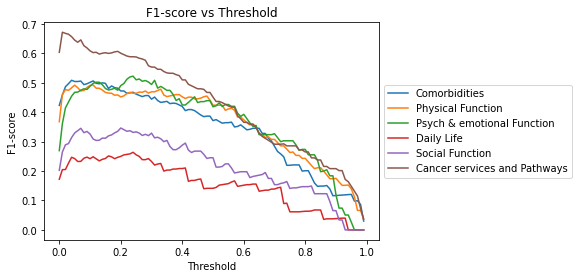

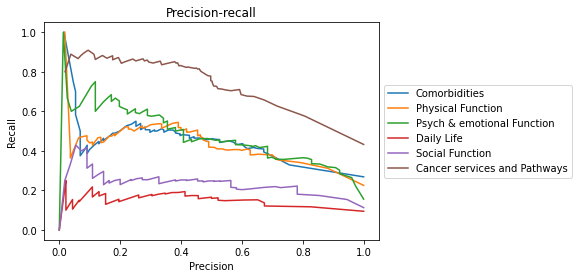

In [ ]:
y_true = true_labelled.iloc[:,1:].astype(int).to_numpy()
comments = predicted_text['Pateint Comment']

themes = predicted_text.columns[1:]

precision_recall_(predicted_text, true_labelled, y_true,comments, themes)

In [ ]:
for x in themes:
    print(x)
    pred_test = pd.Series(np.where(pred_test_copy[x] >= 0.1, 1, 0))
    bin_labs.append(list(pred_test))    
    

bins_labs = np.array(bin_labs).T.tolist()

pred_labs = pd.DataFrame(bins_labs, columns =["Pateint Comment","Comorbidities", "Physical Function",
                                             "Psychological & Emotional Function ", "Daily Life",
                                              "Social Function", "Cancer & Services"])

In [ ]:
# table of the comments and the topics they are labelled with
topic_df = pd.DataFrame(
    model.transform(fulldata_X.toarray().astype(int)), 
    columns=["topic_{}".format(i+1) for i in range(6)]
).astype(float)

print(len(topic_df))
topic_df.index = dataf.index

dataf = pd.concat([dataf, topic_df], axis=1)

dataf.head()

In [93]:
# Print the most associated word and save as a dataframe
topic_word = model.topic_word_
n_top_words = 25
assoc_words =[]

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
#     print('Topic {}: {}'.format(i, ' '.join(topic_words)))
    assoc_words.append(', '.join(topic_words))
    
keyword_df = pd.DataFrame(assoc_words)
keyword_df

,0
0,"life, feel, help, live, time, think, positive,..."
1,"scan, surgery, check, test, year, month, bowel..."
2,"bowel, bowel cancer, liver, operation, treatme..."
3,"care, hospital, treatment, nurse, receive, exc..."
4,"problem, bowel, operation, time, cause, pain, ..."
